--- 1/3. Ładowanie danych z wymuszonym schematem ---

--- 4. Rozdzielenie daty (rok z tytułu + symulacja) ---


movieId,title_clean,genres,rok,miesiac,dzien,godzina
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,2,27,13
2,Jumanji,Adventure|Children|Fantasy,1995,2,27,13
3,Grumpier Old Men,Comedy|Romance,1995,2,27,13
4,Waiting to Exhale,Comedy|Drama|Romance,1995,2,27,13
5,Father of the Bride Part II,Comedy,1995,2,27,13



--- 5. Rozbijanie gatunków (Explode) ---

--- 7. Konwersja timestamp na datę (Ratings) ---

--- 8/9. Agregacja ocen wg roku i miesiąca ---

--- 11. Konwersja timestamp na datę (Tags) ---

--- 12. Liczba tagów wg miesiąca i wykres (Wykres 1) ---

--- 15. Agregacja ocen wg tytułu ---

--- 17. Pobranie danych dla avg_rating >= 4.5 ---
Pobrano 692 liczników ocen dla avg_rating >= 4.5.

--- 18. Obliczenie release_to_rating_year ---

--- 21. Liczba ocen wg czasu od premiery (agregacja) ---

--- 24. Wyświetlanie histogramu (Wykres 2) ---

--- 33. Agregacja tagów wg email ---
Teksty tagów (wydruk fragmentu listy, 6 rekordów): ['assassin Jean Reno assassin assassin-in-training (scene) espionage Robert Ludlum', 'based on a book dark comedy narrated reciprocal spectator reciprocal spectator documentary Animation Documentary Henry Darger the catholic church is the most corrupt organization in history childish naivity friendship adventure Bechdel Test:Fail cartoon children computer animation divor

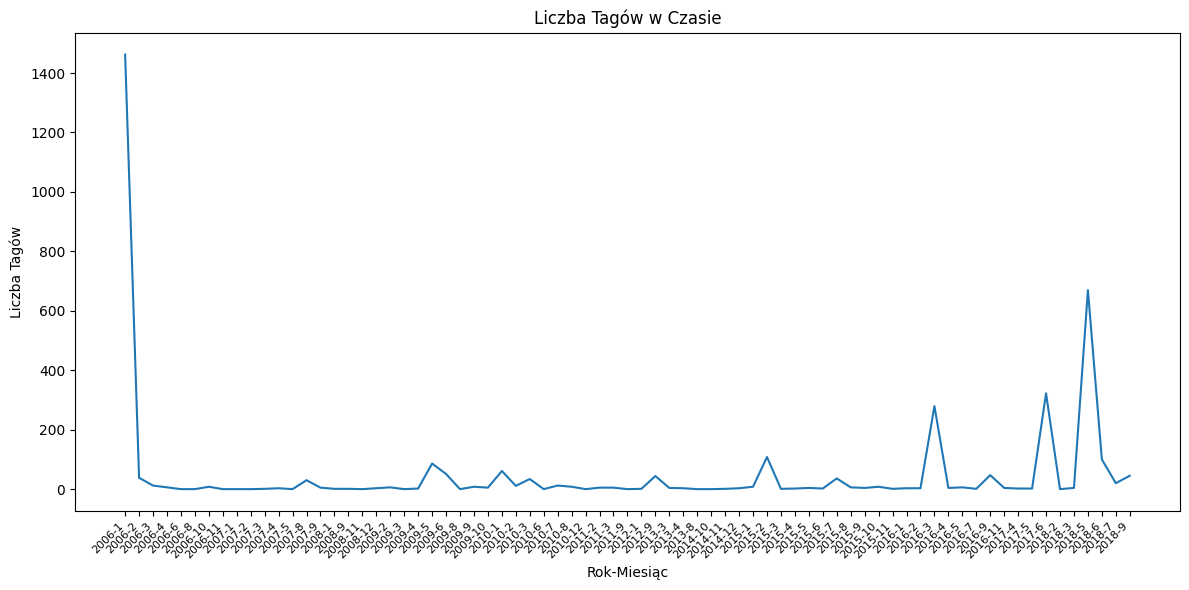

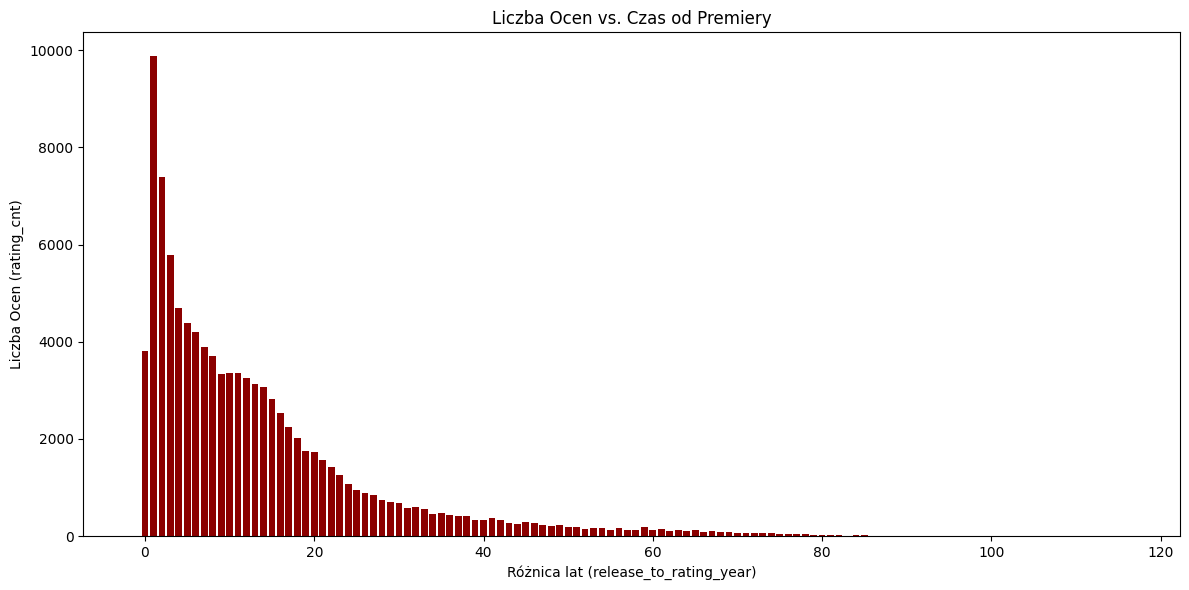

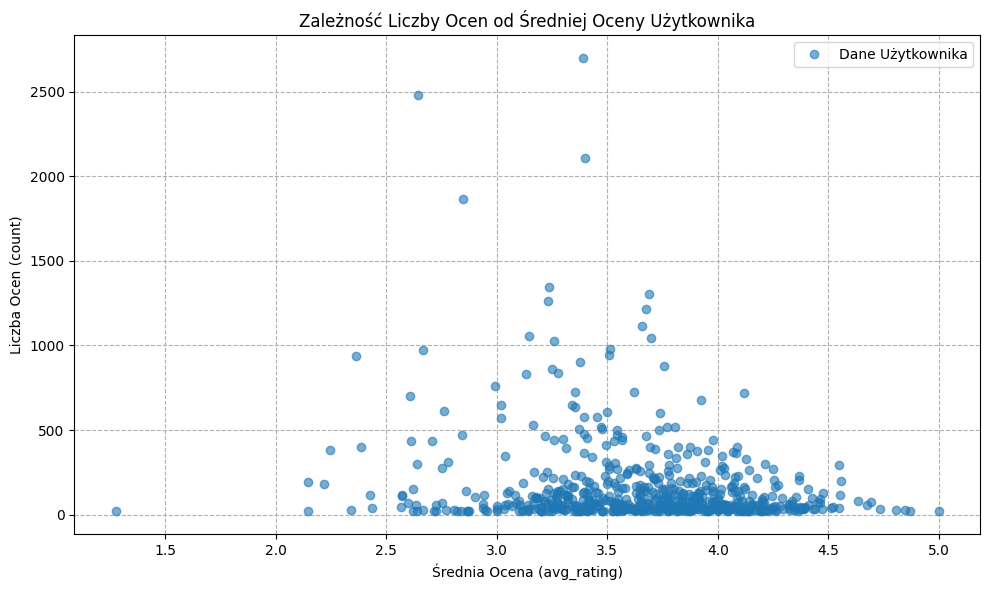

In [0]:
import sys
import matplotlib.pyplot as plt
import numpy as np

# A. IMPORTY I INICJALIZACJA
# ------------------------------------------------------------------------
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pyspark.sql.types as T

# Definicja ścieżek
base_path = "/Workspace/Users/13815@eans-nt.edu.pl"
PATH_MOVIES = f"{base_path}/movies.csv"
PATH_USERS = f"{base_path}/users.csv"
PATH_RATINGS = f"{base_path}/ratings.csv"
PATH_TAGS = f"{base_path}/tags.csv"
PATH_OUTPUT = f"{base_path}/lab2_wyniki"

spark = SparkSession.builder.appName("Lab2_Consolidated_Final").getOrCreate()


# B. DEFINICJE SCHEMATÓW
# ------------------------------------------------------------------------
schema_movies = StructType([
    StructField("movieId", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("genres", StringType(), True)
])
schema_users = StructType([
    StructField("userId", IntegerType(), True),
    StructField("foreName", StringType(), True),
    StructField("surName", StringType(), True),
    StructField("email", StringType(), True)
])
schema_ratings = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", DoubleType(), True),
    StructField("timestamp", LongType(), True)
])
schema_tags = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("tag", StringType(), True),
    StructField("timestamp", LongType(), True)
])


# ========================================================================
# KROK 1: ŁADOWANIE DANYCH
# ========================================================================

print("--- 1/3. Ładowanie danych z wymuszonym schematem ---")
df_movies = spark.read.csv(PATH_MOVIES, header=True, schema=schema_movies, encoding="UTF-8")
df_users = spark.read.csv(PATH_USERS, header=True, schema=schema_users, encoding="UTF-8")
df_ratings_raw = spark.read.csv(PATH_RATINGS, header=True, schema=schema_ratings, encoding="UTF-8")
df_tags_raw = spark.read.csv(PATH_TAGS, header=True, schema=schema_tags, encoding="UTF-8")



# ========================================================================
# KROK 2: PRZETWARZANIE FILMY (MOVIES)
# ========================================================================

# 4. Dodanie kolumn daty
print("\n--- 4. Rozdzielenie daty (rok z tytułu + symulacja) ---")
regex_year_title = r"^(.*?)\s*\((\d{4})\)\s*$"
extracted_year = F.regexp_extract(F.trim(F.col("title")), regex_year_title, 2)

df_movies_parsed = (
    df_movies
    .withColumn("rok_raw", F.regexp_extract(F.col("title"), regex_year_title, 2))
    .withColumn(
        "rok",
        F.when(F.col("rok_raw").rlike("^[0-9]{4}$"),
               F.col("rok_raw").cast("int"))
         .otherwise(None)
    )
    .withColumn(
        "title_clean",
        F.when(
            F.regexp_extract(F.col("title"), regex_year_title, 1) == "",
            F.col("title")
        ).otherwise(
            F.regexp_extract(F.col("title"), regex_year_title, 1)
        )
    )
    .withColumn("miesiac", F.lit(2))
    .withColumn("dzien", F.lit(27))
    .withColumn("godzina", F.lit(13))
    .drop("rok_raw")
)

df_movies_parsed = df_movies_parsed.filter(F.col("rok").isNotNull())
display(
    df_movies_parsed.select(
        "movieId", "title_clean", "genres", "rok", "miesiac", "dzien", "godzina"
    ).limit(5)
)

# 5. Rozbijanie gatunków (Explode)
print("\n--- 5. Rozbijanie gatunków (Explode) ---")
df_movies_exploded = df_movies_parsed.withColumn(
    "genre",
    F.explode(F.split(F.col("genres"), "\\|"))
).drop("genres", "miesiac", "dzien", "godzina", "title")


# ========================================================================
# KROK 3: PRZETWARZANIE OCEN (RATINGS)
# ========================================================================

# 7. Dodawanie kolumn daty z timestamp
print("\n--- 7. Konwersja timestamp na datę (Ratings) ---")
df_ratings = df_ratings_raw.withColumn(
    "datetime",
    F.from_unixtime(F.col("timestamp")).cast(TimestampType())
).withColumn(
    "year",
    F.year(F.col("datetime"))
).withColumn(
    "month",
    F.month(F.col("datetime"))
).withColumn(
    "day",
    F.dayofmonth(F.col("datetime"))
)

# 8. & 9. Liczba ocen wg roku i miesiąca
print("\n--- 8/9. Agregacja ocen wg roku i miesiąca ---")
df_ratings_by_year = df_ratings.groupBy("year").count().orderBy(F.col("year").asc())
df_ratings_by_month = df_ratings.groupBy("year", "month").count().orderBy(F.col("year").asc(), F.col("month").asc())


# ========================================================================
# KROK 4: PRZETWARZANIE TAGI (TAGS)
# ========================================================================

# 11. Konwersja timestamp tagów
print("\n--- 11. Konwersja timestamp na datę (Tags) ---")
df_tags = df_tags_raw.withColumn(
    "datetime",
    F.from_unixtime(F.col("timestamp")).cast(TimestampType())
).withColumn(
    "year",
    F.year(F.col("datetime"))
).withColumn(
    "month",
    F.month(F.col("datetime"))
).withColumn(
    "day",
    F.dayofmonth(F.col("datetime"))
)

# 12. Liczba tagów wg miesiąca i wykres
print("\n--- 12. Liczba tagów wg miesiąca i wykres (Wykres 1) ---")
df_tags_by_month = df_tags.groupBy("year", "month").count().orderBy("year", "month")
tags_data_pd = df_tags_by_month.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(tags_data_pd['year'].astype(str) + '-' + tags_data_pd['month'].astype(str), tags_data_pd['count'])
plt.title('Liczba Tagów w Czasie')
plt.xlabel('Rok-Miesiąc')
plt.ylabel('Liczba Tagów')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.savefig(f"{PATH_OUTPUT}/tags_by_month_plot.png")


# ========================================================================
# KROK 5: AGREGACJE GŁÓWNE I CZAS OD PREMIERY
# ========================================================================

# 14. Join Movies (z rokiem) i Ratings
df_mr = df_movies_parsed.join(df_ratings, on="movieId", how="inner").drop(df_ratings["movieId"])
df_mr = df_mr.drop("genres")


# 15. Agregacja ocen wg tytułu
print("\n--- 15. Agregacja ocen wg tytułu ---")
df_mr_t = df_mr.groupBy("title_clean").agg(
    F.min("rating").alias("min_rating"),
    F.avg("rating").alias("avg_rating"),
    F.max("rating").alias("max_rating"),
    F.count("rating").alias("rating_cnt")
).orderBy(F.col("rating_cnt").desc())


# 17. Pobranie wartości (Task 16/17)
print("\n--- 17. Pobranie danych dla avg_rating >= 4.5 ---")
df_high_ratings = df_mr_t.filter(F.col("avg_rating") >= 4.5)

rating_cnt_list = df_high_ratings.select("rating_cnt").toPandas()["rating_cnt"].tolist()
print(f"Pobrano {len(rating_cnt_list)} liczników ocen dla avg_rating >= 4.5.")


# 18. Dodaj kolumnę release_to_rating_year
print("\n--- 18. Obliczenie release_to_rating_year ---")
df_mr_release = df_mr.withColumn(
    "rok_int",
    F.when(F.col("rok").rlike("^[0-9]{4}$"), F.col("rok").cast("int"))
     .otherwise(None)
).withColumn(
    "release_to_rating_year",
    (F.year("datetime") - F.col("rok_int")).cast("double")
)
df_mr_release = df_mr_release.filter(F.col("rok_int").isNotNull())




# 20. Downsampling (1% danych)
ratio = 0.01 
df_mr_sampled = df_mr_release.sample(False, ratio, seed=42)

# 21. Grupuj po release_to_rating_year i zlicz
print("\n--- 21. Liczba ocen wg czasu od premiery (agregacja) ---")
df_release_count = df_mr_release.groupBy("release_to_rating_year").count()
df_release_count = df_release_count.withColumnRenamed("count", "rating_cnt")
df_release_count = df_release_count.orderBy(F.col("release_to_rating_year").asc())


# 24. Wyświetl histogram (Wykres 2)
print("\n--- 24. Wyświetlanie histogramu (Wykres 2) ---")
hist_data = df_release_count.filter(F.col("release_to_rating_year").isNotNull()).collect()
x_hist = [row['release_to_rating_year'] for row in hist_data]
y_hist = [row['rating_cnt'] for row in hist_data]

plt.figure(figsize=(12, 6))
plt.bar(x_hist, y_hist, width=0.8, color='darkred')
plt.title('Liczba Ocen vs. Czas od Premiery')
plt.xlabel('Różnica lat (release_to_rating_year)')
plt.ylabel('Liczba Ocen (rating_cnt)')
plt.tight_layout()
plt.savefig(f"{PATH_OUTPUT}/release_time_histogram_final.png")


# ========================================================================
# KROK 6: ANALIZA GATUNKÓW I SQL
# ========================================================================

# 26. Join MoviesRatingsGenres (Explode Genres i Join)
df_mrg = df_movies_exploded.join(df_ratings, on="movieId", how="inner")

# 27. Zgrupuj dane po kolumnie genre i wylicz statystyki
df_mrg_agg = df_mrg.groupBy("genre").agg(
    F.min("rating").alias("min_rating"),
    F.avg("rating").alias("avg_rating"),
    F.max("rating").alias("max_rating"),
    F.count("rating").alias("rating_cnt")
).orderBy(F.col("rating_cnt").desc())

# 29. & 30. Filtracja ocen powyżej średniej ogólnej (SQL Subquery)
df_mrg.createOrReplaceTempView("movies_ratings_genres_expanded")
df_ratings.createOrReplaceTempView("ratings")

query = """
    SELECT 
        genre, 
        AVG(rating) AS avg_rating, 
        COUNT(rating) AS rating_cnt
    FROM movies_ratings_genres_expanded 
    GROUP BY genre 
    HAVING AVG(rating) > (SELECT AVG(rating) FROM ratings) 
    ORDER BY avg_rating DESC
"""
df_cat_above_avg = spark.sql(query)


# ========================================================================
# KROK 7: ANALIZA UŻYTKOWNIKÓW (TAGI I OCENY)
# ========================================================================
df_users_strict = df_users

# 31. - 33. Join UsersTags i agregacja tagów
df_ut = df_users_strict.join(df_tags_raw, on="userId", how="inner")

print("\n--- 33. Agregacja tagów wg email ---")
df_tags_by_email = df_ut.groupBy("email").agg(
    F.collect_list("tag").alias("tag_list")
).withColumn(
    "tags",
    F.concat_ws(" ", F.col("tag_list"))
).drop("tag_list")

tags_list = df_tags_by_email.select("tags").toPandas()["tags"].tolist()
print(f"Teksty tagów (wydruk fragmentu listy, 6 rekordów): {tags_list[:6]}")


# 34. - 36. Join UserRatings i agregacja ocen
df_ur = df_users_strict.join(df_ratings, on="userId", how="inner")

print("\n--- 36. Agregacja ocen wg email (avg_rating, count) ---")
df_ur_agg = df_ur.groupBy("email").agg(
    F.avg("rating").alias("avg_rating"),
    F.count("rating").alias("count")
).orderBy(F.col("avg_rating").desc())


# 37. Wyświetl wykres punktowy (Wykres 3)
print("\n--- 37. Wyświetlenie wykresu punktowego (Scatter Plot) ---")
ur_data_pd = df_ur_agg.toPandas()

x = ur_data_pd['avg_rating']
y = ur_data_pd['count']

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label="Dane Użytkownika", alpha=0.6)
plt.title('Zależność Liczby Ocen od Średniej Oceny Użytkownika')
plt.xlabel('Średnia Ocena (avg_rating)')
plt.ylabel('Liczba Ocen (count)')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig(f"{PATH_OUTPUT}/user_rating_scatter_final.png")
print("Wszystkie zadania wykonane pomyślnie. Wykresy zapisane w folderze Workspace.")